# ADNI Merge

In [1]:
from IPython.core.display import HTML
with open("./project.css") as css:
    styles = css.read()
HTML(styles)

## ADNI

The overarching goal of the Alzheimer's Disease Neuroimaging Initiative (ADNI) is to identify biomarkers of Alzheimer’s disease. Specifically the study aims at identifying those biomarkers that can be used in the earliest (pre-dementia) prediction of Alzheimer's Disease (AD). The study began in 2004, a time when biomarkers for Alzheimer’s disease which could be used for diagnostics in pre-dementia individuals were virtually unknown. There are four categories of biomarkers in the scope of the initiative: (clinical, imaging, genetic, and biochemical).

There have been ADNI 4 study phases to date with the following goals:

<!-- Begin ADNI Phase table -->

| Study Phase | Goal | Dates | Cohort |
|:---: |:--- |:--- | --- |
| ADNI 1 | Develop biomarkers as outcome measures for clinical trials | 2004-2009 | 200 elderly controls<br>400 MCI<br>200 AD |
| ADNI GO | Examine biomarkers in earlier stages of disease | 2009-2011 | Existing ADNI-1 +<br>200 early MCI |
| ADNI 2 | Develop biomarkers as predictors of cognitive decline, and as outcome measures | 2011-2016 | Existing ADNI-1 and ADNI-GO +<br>150 elderly controls<br>100 early MCI<br>150 late MCI<br>150 AD |
| ADNI 3 | Study the use of tau PET and functional imaging techniques in clinical trials | 2016 - present | Existing ADNI-1, ADNI-GO, ADNI-2 +<br>133 elderly controls<br>151 MCI<br>87 AD |

<!-- End ADNI phase table -->

## ADNI Data
Before looking at a single observation or feature, there is a lot of information we can glean from reviewing ADNI metadata. There are over 250 datasets in the ADNI data inventory spanning the 4 study phases (ADNI 1, GO, 2, 3) - and this number does not include the archives. These studies are longitudinal. ADNI-1 started in 2004 and ADNI-3 continues today. Although there is potentially a wealth of information, insights, and predictive power in these data, their data collection methods and longitudinal nature present many challenges.

One challenge is that all biometrics within the scope of the study are not collected across all study phases. Also, within each phase, not all participants had all measurements taken. For example, in ADNI-1, $100\%$ of the cohort had a 1.5 Tesla (1.5T) MRI, $50\%$ had a PET scan. Of the $50\%$ that didn't have a PET scan, $25\%$ had a 3T MRI. Finally, only $20\%$ of the ADNI-1 cohort had a lumbar puncture (L.P.) to collect cerebral spinal fluid (CSF).

Other data challenges are related to the longitudinal nature of the studies across the different phases. In each successive phase of the study, participants were rolled over from previous phases while new participants were also added - *(cohort details can be seen in the table above)*. However, existing participants in the study must provide their consent to be included in each subsequent phase. Furthermore, an obvious, but nonetheless real, complication with this population is that a participant could be removed from the study at any time due to significant deterioration in health or death. 

The result is that each phase of the study produces a richer set of longitudinal data than the previous study because of the rollover participants. The downside of this design is the inherent introduction of missingness into the data due to the recently joined participants.

### An initial look at the data.
Given the breadth of available data and the challenges mentioned above, deciding what data to use to start EDA is a non-trivial task. Fortunately, there is a combined dataset available consisting of key ADNI tables merged into a single table based on the patient identifier or `RID`. As is common with most ADNI datasets, each observation represents a single visit for a participant. This means that a single participant (`RID`) may appear multiple times in the dataset. The number of occurrences will generally depend on what phase the participant entered the study.

Let's take an initial look at the merged dataset.

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ADNI_utilities as utils

from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import RBF
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR


### Stacking libraries require mlxtend
### conda install mlxtend --channel conda-forge
from mlxtend.classifier import StackingCVClassifier
from mlxtend.regressor import StackingCVRegressor

# Use the following to install mlxtend and to
# update other libs to required (latest) versions
"""
conda config --add channels conda-forge
conda install -y mlxtend
conda update -y pandas
conda update -y numpy
conda update -y scikit-learn --no-channel-priority
"""

'\nconda config --add channels conda-forge\nconda install -y mlxtend\nconda update -y pandas\nconda update -y numpy\nconda update -y scikit-learn --no-channel-priority\n'

In [3]:
adni_merge = pd.read_csv('../data/ADNIMERGE.csv', low_memory=False)

In [4]:
print("The shape of the dataset is {}.".format(adni_merge.shape))
print("There are {} unique participants in the dataset."
      .format(len(adni_merge.RID.unique())))
print("There is an average of {:.2f} rows in the data per participant."
      .format(len(adni_merge)/len(adni_merge.RID.unique())))

The shape of the dataset is (13632, 113).
There are 2081 unique participants in the dataset.
There is an average of 6.55 rows in the data per participant.


As seen above, the dataset contains $2081$ unique study participants spanning $13632$ visits. The data is longitudinal based on participant visits spaced roughly six months apart. The `VISCODE` feature represents the visit in which the measurements and evaluations were captured. The initial evaluation measurements are identified by `VISCODE` = `'bl'`, which stands for baseline. Below are the unique `VISCODE` values in the dataset:

In [5]:
adni_merge.sort_values(by='Month')['VISCODE'].unique()

array(['bl', 'm03', 'm06', 'm12', 'm18', 'm24', 'm36', 'm30', 'm42',
       'm48', 'm54', 'm60', 'm66', 'm72', 'm78', 'm84', 'm90', 'm96',
       'm102', 'm108', 'm114', 'm120', 'm126', 'm132', 'm144', 'm156'],
      dtype=object)

Let's visualize the number of study participants per `VISCODE`.

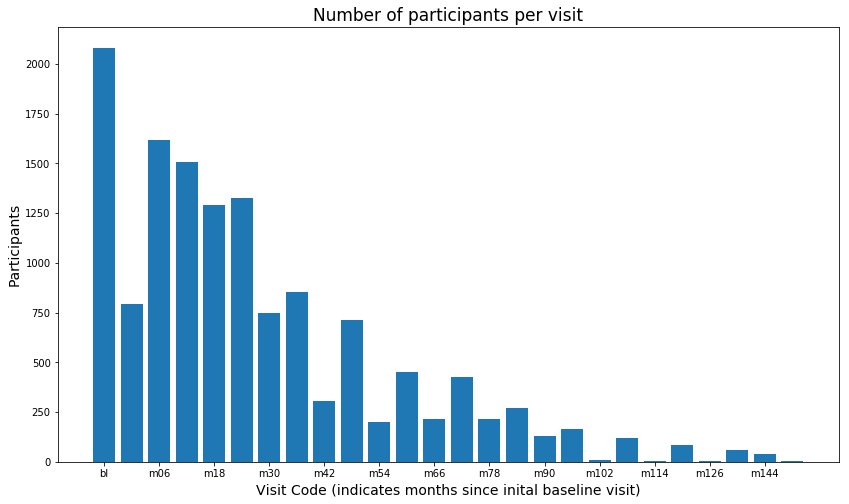

In [6]:
# M represents months since the last visit (0 = baseline/initial visit)
adni_by_month = adni_merge.groupby(by='M').count()
particpants = adni_by_month['RID']
visits = adni_merge.sort_values(by='M')['VISCODE'].unique()

fig, ax = plt.subplots(1, 1, figsize=(14,8))

ax.set_title('Number of participants per visit', size=17)
ax.set_xticks(range(0, 26, 2))
ax.set_xlabel('Visit Code (indicates months since inital baseline visit)', size=14)
ax.set_ylabel('Participants', size=14)
ax.bar(visits, particpants)

plt.show()

Based on the design of the study as discussed above, we expect there to be a lot of missing data in this data set. Let's take a look.

In [7]:
# Calculate missing data
missing_data = utils.calculate_missing_data(adni_merge)

# Look at the top 10 columns in terms of missing values
missing_data.head(10)

There are a total of 507270 missing values.
Out of 113 features in the dataset, 93 have missing values.

Quartiles of missing data:
      Num Missing  Pct. Missing
0.25       3839.0     28.161678
0.50       6185.0     45.371185
0.75       7758.0     56.910211
1.00      13632.0    100.000000


,Num Missing,Pct. Missing
FLDSTRENG_bl,13632.0,100.000000
FLDSTRENG,13632.0,100.000000
PIB_bl,13483.0,98.906984
PIB,13409.0,98.364143
PTAU,11262.0,82.614437
ABETA,11261.0,82.607101
TAU,11261.0,82.607101
AV45,11122.0,81.587441
FDG,10125.0,74.273768
DIGITSCOR,9832.0,72.124413


We've noticed that the numbers of non-null values for `PTAU`, `ABETA`, and `TAU` are suspiciously close to the number of unique participants. The fact that these features all have almost the exact same number of missing values could be an artifact of how and when these data were collected. Perhaps these were collected on the initial baseline `bl` visit.

In [8]:
missing_proteins = missing_data.loc[['TAU', 'PTAU', 'ABETA']]
missing_proteins['Num Values Present'] = len(adni_merge) - missing_proteins['Num Missing']
missing_proteins['Num Participants'] = len(adni_merge.RID.unique())
missing_proteins

,Num Missing,Pct. Missing,Num Values Present,Num Participants
TAU,11261.0,82.607101,2371.0,2081
PTAU,11262.0,82.614437,2370.0,2081
ABETA,11261.0,82.607101,2371.0,2081


There are many options to deal with the variable number of visits in the merged data set. Instead of vertically stacking the visits as in the merged dataset, we could split on `VISCODE` and stack the data *horizontally* creating wide rows with many more features. However, this is essentially transposing the data and moving the missing values from deep columns to wide rows. Another option is to split the data into multiple subsets of data based on `VISCODE` and deal with them separately. As shown in the "*Participants per visit*" figure, every participant had at least a baseline visit. This subset should provide the most complete and uniform representation of the data.

In [9]:
baseline = adni_merge[adni_merge['VISCODE'] == 'bl'].copy()
print('Shape of the baseline visit subset: ', baseline.shape)

baseline.head()

Shape of the baseline visit subset:  (2081, 113)


,RID,PTID,VISCODE,SITE,COLPROT,ORIGPROT,EXAMDATE,DX_bl,AGE,PTGENDER,...,TAU_bl,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,011_S_0002,bl,11,ADNI1,ADNI1,2005-09-08,CN,74.3,Male,...,NaN,NaN,1.36665,NaN,NaN,0.0,0.0,0,0,2018-10-19 22:51:15.0
1,3,011_S_0003,bl,11,ADNI1,ADNI1,2005-09-12,AD,81.3,Male,...,239.7,22.83,1.08355,NaN,NaN,0.0,0.0,0,0,2018-10-19 22:51:15.0
5,4,022_S_0004,bl,22,ADNI1,ADNI1,2005-11-08,LMCI,67.5,Male,...,153.1,13.29,NaN,NaN,NaN,0.0,0.0,0,0,2018-10-19 22:51:15.0
10,5,011_S_0005,bl,11,ADNI1,ADNI1,2005-09-07,CN,73.7,Male,...,337,33.43,1.29343,NaN,NaN,0.0,0.0,0,0,2018-10-19 22:51:15.0
15,6,100_S_0006,bl,100,ADNI1,ADNI1,2005-11-29,LMCI,80.4,Female,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0,2018-10-19 22:51:15.0


Let's examime the missing data from the baseline visit dataset.

In [10]:
# Calculate missing data
missing_data = utils.calculate_missing_data(baseline)

There are a total of 54057 missing values.
Out of 113 features in the dataset, 91 have missing values.

Quartiles of missing data:
      Num Missing  Pct. Missing
0.25         22.0      1.057184
0.50        728.0     34.983181
0.75        851.0     40.893801
1.00       2081.0    100.000000


## Filling in Missing Data
Based on the study data, we know that not all biometrics are measured at every visit. Therefore we may be able to pull measures together from different visits to help fill in missing data. Of course since we're dealing with longitudinal data with visits month or years apart, we have to make sure that we only consider measures from visits where the diagnosis code is unchanged.

In [11]:
# For every column in the baseline (VISCODE='bl') with missing values, look for
# a value in subsequent visits with the constraint that the DX code must
# not have changed. Take the first (earliest) biometric measure available.

baseline.sort_values(by='RID')
missing_cols = baseline.columns[baseline.isnull().any()]
viscodes = list(adni_merge.sort_values(by='Month')['VISCODE'].unique())
viscodes.pop(0) # Get rid of 'bl'

missing_values = baseline.isnull().sum().sum()
updated_values = 0

print('Searching...')
for col in missing_cols:
    
    for v in viscodes:
        
        # Get the RIDs with missing values in this colummn.
        # Do this for each VISCODE since we are iteratively
        # updating missing values.
        rids = baseline[baseline[col].isnull()].RID
        
        # Create a DataFrame from adni_merge for the current
        # VISCODE, RIDs, & where current col is not null.
        df = adni_merge.loc[(adni_merge.RID.isin(rids))
                            & (adni_merge.VISCODE == v)
                            & (adni_merge[col].notnull()),
                            baseline.columns] 
               
        if df.empty: # if no matches, continue
            continue
            
        df = df.copy()
        df.sort_values(by='RID', inplace=True)
            
        # Find baseline participants who are also in the current VISCODE
        bl = baseline[baseline.RID.isin(df.RID)].copy()
        bl.sort_values(by='RID', inplace=True)
        df.index = bl.index
        
        # Only keep those where the diagnosis is unchanged & col is not null
        df = df[(df.DX == bl.DX) & (df[col].notnull())]

        if df.empty:  # if DX codes don't match, continue
            continue

        # Update null values in the original baseline DF
        baseline.loc[baseline.index.isin(df.index), col] = df[col]
        updated_values += len(df)

print(f'Updated {updated_values} of {missing_values} missing values.')

Searching...
Updated 4104 of 54057 missing values.


In [12]:
# Calculate missing data
missing_data = utils.calculate_missing_data(baseline)

# Look at the top 10 columns in terms of missing values
missing_data.head(10)

There are a total of 49953 missing values.
Out of 113 features in the dataset, 91 have missing values.

Quartiles of missing data:
      Num Missing  Pct. Missing
0.25         21.0      1.009130
0.50        641.0     30.802499
0.75        832.0     39.980778
1.00       2081.0    100.000000


,Num Missing,Pct. Missing
FLDSTRENG,2081.0,100.000000
FLDSTRENG_bl,2081.0,100.000000
PIB_bl,2061.0,99.038924
PIB,1990.0,95.627102
DIGITSCOR_bl,1267.0,60.884190
DIGITSCOR,1264.0,60.740029
AV45_bl,1107.0,53.195579
AV45,971.0,46.660259
EcogSPOrgan_bl,891.0,42.815954
PTAU_bl,866.0,41.614608


Clearly a lot of missing data remain and we will likely have to explore methods to impute these values. Before doing that however, we will explore the data a little closer to see if there are features that should be dropped due to high correlation, lack of information, or other reasons.

`FLDSTRENG` and `FLDSTRENG_bl` are providing absolutely no information so we can drop them.

In [13]:
baseline = baseline.drop(labels=['FLDSTRENG', 'FLDSTRENG_bl'], axis=1)

There appears to be a lot of features with similar, if not identical, information such as `TAU`, `TAU_bl`, `AV45`, `AV45_bl`. Let's examine this pattern to see if these pairs are highly correlated.

In [14]:
# Generate a correlation matrix of xxx_bl vs xxx
corr_df = baseline.corr()
cols = baseline.columns
col1, col2, corr = [], [], []

# Specifically check the correlation of xxx_bl to xxx
for col in cols:
    if '_bl' in col.lower(): 
        drop_bl = col[0:-3]
        if (drop_bl in cols):
            if (col in corr_df.index and corr_df.loc[col][drop_bl] > .8):
                col1.append(col)
                col2.append(drop_bl)
                corr.append(corr_df.loc[col][drop_bl])

# Display the results                
bl_corr_df = pd.DataFrame({"Baseline column": col1, 'Alternate column': col2, "Correlation": corr})
bl_corr_df

,Baseline column,Alternate column,Correlation
0,CDRSB_bl,CDRSB,1.0
1,ADAS11_bl,ADAS11,1.0
2,ADAS13_bl,ADAS13,1.0
3,ADASQ4_bl,ADASQ4,1.0
4,MMSE_bl,MMSE,1.0
5,RAVLT_immediate_bl,RAVLT_immediate,1.0
6,RAVLT_learning_bl,RAVLT_learning,1.0
7,RAVLT_forgetting_bl,RAVLT_forgetting,1.0
8,RAVLT_perc_forgetting_bl,RAVLT_perc_forgetting,1.0
9,LDELTOTAL_BL,LDELTOTAL,1.0


These features indeed contain duplicate information so we can drop one of each pair.

In [15]:
baseline = baseline.drop(labels=bl_corr_df['Baseline column'].values, axis=1)
print("The new shape of the baseline subset is {}.".format(baseline.shape))

The new shape of the baseline subset is (2081, 71).


In [16]:
# Let's see what features we have now
baseline.columns.sort_values()

Index(['ABETA', 'ABETA_bl', 'ADAS11', 'ADAS13', 'ADASQ4', 'AGE', 'APOE4',
       'AV45', 'CDRSB', 'COLPROT', 'DIGITSCOR', 'DX', 'DX_bl', 'EXAMDATE',
       'EXAMDATE_bl', 'EcogPtDivatt', 'EcogPtLang', 'EcogPtMem', 'EcogPtOrgan',
       'EcogPtPlan', 'EcogPtTotal', 'EcogPtVisspat', 'EcogSPDivatt',
       'EcogSPLang', 'EcogSPMem', 'EcogSPOrgan', 'EcogSPPlan', 'EcogSPTotal',
       'EcogSPVisspat', 'Entorhinal', 'FAQ', 'FDG', 'FSVERSION',
       'FSVERSION_bl', 'Fusiform', 'Hippocampus', 'ICV', 'IMAGEUID',
       'LDELTOTAL', 'M', 'MMSE', 'MOCA', 'MidTemp', 'Month', 'Month_bl',
       'ORIGPROT', 'PIB', 'PTAU', 'PTAU_bl', 'PTEDUCAT', 'PTETHCAT',
       'PTGENDER', 'PTID', 'PTMARRY', 'PTRACCAT', 'RAVLT_forgetting',
       'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_perc_forgetting', 'RID',
       'SITE', 'TAU', 'TAU_bl', 'TRABSCOR', 'VISCODE', 'Ventricles',
       'WholeBrain', 'Years_bl', 'mPACCdigit', 'mPACCtrailsB', 'update_stamp'],
      dtype='object')

We still have some columns that look very similar. These may contain non-numeric values such as strings or NaNs, or possibly they are really uncorrelated.

In [17]:
# Columns to check for duplicates
cols = ['ABETA', 'DX', 'EXAMDATE','FSVERSION',  'PTAU', 'TAU']

bl_missing = []
missing = []
matching_vals = []

for col in cols:
    missing.append(baseline[col].isnull().sum())
    bl_missing.append(baseline[col+'_bl'].isnull().sum())
    match = (baseline[col] == baseline[col+'_bl']).sum()
    matching_vals.append((match + min(missing[-1], bl_missing[-1]))/len(baseline) * 100)
                 
# Display the results                
bl_dupes = pd.DataFrame({'Missing Values': missing,
                            'Baseline Missing Values': bl_missing,
                            'Percent Matching': matching_vals}, index=cols)
bl_dupes

,Missing Values,Baseline Missing Values,Percent Matching
ABETA,832,866,98.366170
DX,25,16,24.939933
EXAMDATE,0,0,100.000000
FSVERSION,346,357,99.471408
PTAU,832,866,98.366170
TAU,832,866,98.366170


All of the pairs are nearly exact duplicates except `DX`|`DX_bl`, so we can drop one of the duplicate columns. The baseline versions have slightly more missing data, so we'll drop those. Then we'll take a look at `DX` vs.`DX_bl`.

In [18]:
# Get a list of duplicate column names to drop
dupe_cols = [col + '_bl' for col in cols]

# Remove DX_bl until we investigate further
del dupe_cols[dupe_cols.index('DX_bl')]

# Drop the columns
baseline = baseline.drop(labels=dupe_cols, axis=1)

In [19]:
# See how DX maps to DX_bl
baseline.drop_duplicates('DX_bl')[['DX_bl', 'DX']]

,DX_bl,DX
0,CN,CN
1,AD,Dementia
5,LMCI,MCI
48,SMC,CN
2848,EMCI,MCI
11389,NaN,NaN


Although similar, the diagnoses in `DX_bl` are more specific than those in `DX`. We'll use the more standard diagnosis codes in `DX`. However `DX_bl` has slightly less missingness so we'll keep that column and remap some of the values to match `DX` where needed.

In [20]:
# Drop DX
baseline = baseline.drop(labels=['DX'], axis=1)

# Remap some of the DX_bl values
baseline.DX_bl = baseline.DX_bl.replace('LMCI','MCI')
baseline.DX_bl = baseline.DX_bl.replace('EMCI','MCI')
baseline.DX_bl = baseline.DX_bl.replace('SMC','CN')

We also have some participants for which we have no diagnosis code, so these records will not be useful and can be dropped.

In [21]:
missing_dx = len(baseline[baseline['DX_bl'].isnull()])
baseline = baseline.dropna(axis=0, subset=['DX_bl'])
print(f'Removed {missing_dx} participants with no diagnosis code.')

Removed 16 participants with no diagnosis code.


`PTID` is also duplicative. It is a combination of `RID` and `SITE`.

In [22]:
baseline = baseline.drop(labels='PTID', axis=1)

In [23]:
print("The new shape of the baseline subset is {}.".format(baseline.shape))
utils.calculate_missing_data(baseline)

The new shape of the baseline subset is (2065, 64).
There are a total of 20821 missing values.
Out of 64 features in the dataset, 44 have missing values.

Quartiles of missing data:
      Num Missing  Pct. Missing
0.25        22.75      1.101695
0.50       541.50     26.222760
0.75       649.00     31.428571
1.00      1974.00     95.593220


,Num Missing,Pct. Missing
PIB,1974.0,95.593220
DIGITSCOR,1248.0,60.435835
AV45,956.0,46.295400
ABETA,816.0,39.515738
TAU,816.0,39.515738
PTAU,816.0,39.515738
EcogSPOrgan,670.0,32.445521
EcogSPDivatt,656.0,31.767554
EcogSPVisspat,654.0,31.670702
EcogSPPlan,651.0,31.525424


In the new dataset, it is clear that `PIB` will not be useful and can be removed. PIB or *PiB* stands for **Pi**ttsburgh Compound-**B** - a synthetic radiotracer developed for use in PET scans to visualize and measure A$\beta$ deposits in the brain.

In [24]:
baseline = baseline.drop(labels='PIB', axis=1)

There are other features in the data that we are confindent won't be helpful in predicting AD. These include features such as `SITE`, `update_stamp`, `EXAMDATE`, etc. We will remove them.

In [25]:
baseline = baseline.drop(labels=['update_stamp', 'Years_bl', 'SITE', 'VISCODE', 'COLPROT', 'ORIGPROT',
                                 'Month_bl', 'M', 'EXAMDATE', 'IMAGEUID'], axis=1)

In [26]:
# Let's see what features we have now
baseline.columns.sort_values()

Index(['ABETA', 'ADAS11', 'ADAS13', 'ADASQ4', 'AGE', 'APOE4', 'AV45', 'CDRSB',
       'DIGITSCOR', 'DX_bl', 'EcogPtDivatt', 'EcogPtLang', 'EcogPtMem',
       'EcogPtOrgan', 'EcogPtPlan', 'EcogPtTotal', 'EcogPtVisspat',
       'EcogSPDivatt', 'EcogSPLang', 'EcogSPMem', 'EcogSPOrgan', 'EcogSPPlan',
       'EcogSPTotal', 'EcogSPVisspat', 'Entorhinal', 'FAQ', 'FDG', 'FSVERSION',
       'Fusiform', 'Hippocampus', 'ICV', 'LDELTOTAL', 'MMSE', 'MOCA',
       'MidTemp', 'Month', 'PTAU', 'PTEDUCAT', 'PTETHCAT', 'PTGENDER',
       'PTMARRY', 'PTRACCAT', 'RAVLT_forgetting', 'RAVLT_immediate',
       'RAVLT_learning', 'RAVLT_perc_forgetting', 'RID', 'TAU', 'TRABSCOR',
       'Ventricles', 'WholeBrain', 'mPACCdigit', 'mPACCtrailsB'],
      dtype='object')

We have some non-numeric data in `ABETA`, `TAU`, and `PTAU`, such as '>1300' or '<80'. We'll remove the `>` and `<` characters and change the dtype to float64.

In [27]:
# remove < or > 
def remove_gt_lt(val):
    if type(val) == str:
        return float(val.replace('>', '').replace('<', ''))
    else:
        return val
    
    
for col in ['ABETA', 'TAU', 'PTAU']:
    values = baseline[col].values
    baseline[col] = list(map(remove_gt_lt, values))

In [28]:
baseline['PTEDUCAT'] = baseline.PTEDUCAT.astype('float')

At this point, we have cleaned the data by removing duplicate/highly correlated or informationless features and filling in missing values that can be found within the collected data. To deal with the remaining missingness, we will impute values. But first we have to make a decision about whether to normalize the data before or after imputation. We have decided to standardize the data before imputing missing values. We reason that imputing on the data before standardization may cover up or dilute any bias present in the data. Also, standardizing the data before imputation is preferred if we use modeling to impute missing data.

There are additional (potentially valuable) data that are not included in the Merged data set. These data have been cleaned and put into a format such that we can join them to the merged data set. We will do that before performing any imputation.

In [29]:
# First set the baseline index to 'RID'
baseline.index = baseline['RID']
baseline = baseline.drop(labels='RID', axis=1)

In [30]:
# Read in the additional patient data. Use RID as the index column
pat_data = pd.read_csv('../data/Per_Patient/patient_firstidx_merge.csv', index_col='RID', na_values='-1')

Let's identify and remove any duplicate columns.

In [31]:
dupes = list(set(baseline.columns) & set(pat_data.columns))
pat_data = pat_data.drop(labels=dupes, axis=1)
print(f'Dropped duplicate columns: {dupes}')

Dropped duplicate columns: ['ABETA', 'PTEDUCAT', 'PTETHCAT', 'PTMARRY', 'TAU', 'PTRACCAT', 'PTGENDER', 'PTAU']


Now we'll merge the ADNI_Merge dataset and cleaned Per_Patient dataset that we've built and curated from raw data files.

In [32]:
# Merge baseline with pat_data
pat_comb = pd.merge(baseline, pat_data, on='RID')

# First drop cols that have only NA values
pat_comb = pat_comb.dropna(axis='columns', thresh=1)

Save the file before imputing.

In [33]:
pat_comb.to_csv('../data/Per_Patient/pat_merge_b4_impute.csv')

Our goal is to strike a balance between keeping as much data as possible and reducing noise introduced by imputing columns that are nearly completely void of information. We will explore the relationship between these by imputing with different thresholds for missing data.

In [34]:
def drop_missing_cols(data, threshold):
    """Drops cols from data that missing values above the threshold.
    
    # Arguments:
        data: The data to drop missing cols from
        threshold: float 0:1, the max allowable percentage of missing values
        
    # Returns
        The data with missing cols dropped.
    """
    cols = data.columns.values

    # Drop columns that don't have at least 1 - threshold non-NA values
    data = data.dropna(axis='columns', thresh=np.floor(data.shape[0] * (1 - threshold)))

    print('Dropped columns due to missingness:\n', set(cols) ^ set(data.columns.values))
    return data

Now we will prepare the categorical variables. Depending on the study, some categorical features use text values like `AD`, `MCI`, `MALE`, `FEMALE`, etc., and some use numerical codes. The per-patient data have been cleaned to and standardized to use numeric values. We will read in a file that identifies the correct dtypes per column.

In [35]:
def get_combined_data(missing_thresh):
    """Gets the raw combined (ADNI_Merge and Per_Patient) datasets. The
    categorical features will have a dtype of 'int'. 
    
    # Returns:
        Returns the combined (ADNI_Merge and Per_Patient) datasets and lists
        of the categorical and non-categorical features.
    """
    # Read in the combined (Merged and Per Patient) dataset
    pat_comb = pd.read_csv('../data/Per_Patient/pat_merge_b4_impute.csv', index_col='RID')
    
    # Drop cols based on missing threshold
    pat_comb = drop_missing_cols(pat_comb, missing_thresh)

    # Import the dtypes. Categorical variables are represented as int64 as opposed to floats.
    dtypes = pd.read_csv('../data/Per_Patient/patient_firstidx_dtypes.csv', index_col='feature_name')

    # Categoricals from baseline
    categoricals = ['PTETHCAT', 'PTGENDER', 'PTRACCAT', 'PTMARRY', 'FSVERSION', 'APOE4', 'DX_bl']
    for cat in categoricals:
        if cat not in pat_comb.columns:
            categoricals.pop(categoricals.index(cat))

    # Collect categorical columns from pat_data based on dtype=int64
    for i in dtypes.index:
        # RID is the index so skip it
        if i == 'RID':
            continue
        # If dtype is int, the it's categorical
        if 'int' in dtypes.loc[i].data_type and i in pat_comb.columns:
            categoricals.append(i)

    # Remove any dupes
    categoricals = list(set(categoricals))
    non_cat = list(set(pat_comb.columns) ^ set(categoricals))
    return pat_comb, categoricals, non_cat

In [36]:
# Set the missing data threshold
missing_thresh = .5

At this point, we have cleaned the data by removing duplicate/highly correlated or informationless features and filling in missing values that can be found within the collected data. To deal with the remaining missingness, we will impute values. But first we have to make a decision about whether to normalize the data before or after imputation. We have decided to normalize the data before imputing missing values. We reason that imputing on the data before normalization may cover up or dilute any bias present in the data. Also, normalizing the data before imputation is preferred if we use modeling to impute missing data.

In [37]:
# Read in data and identify categorical and non-categorical features
pat_comb, categoricals, non_cat = get_combined_data(missing_thresh)

Dropped columns due to missingness:
 {'DXMPTR1', 'MH14AALCH', 'MH16ASMOK', 'HMT95', 'CMT2', 'HMT93', 'DXMPTR4', 'MH15ADRUG', 'CMT3', 'HMT96', 'HMT21', 'DXNORM', 'DIGITSCOR', 'DADAD', 'MH16BSMOK', 'DXMPTR2', 'HMT20', 'AXT117', 'DXNODEP', 'HMT69', 'DXMPTR5', 'MH15BDRUG', 'UAT3', 'UAT2', 'MH16CSMOK', 'MH14BALCH', 'MH14CALCH', 'BAT324', 'DXMPTR3', 'HMT98', 'HMT70'}


In [38]:
# Scale all columns that are non-categorical
pat_comb = utils.scale_cols(data=pat_comb, cols=non_cat, scaler=MinMaxScaler())

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Next we'll use a combination of stacking and grid search to see the effects of missingness and different models on imputation and predictive models. We'll start by defining the classifiers and regressors that we want to evaluate for imputing the missing data.

In [39]:
def make_clf_stack():
    """Convenience function to create a stacking meta classifier.
    
    # Returns:
        A Stacking CV Classifier and a parameter grid.
    """
    # Define classification estimators and their param grids
    cl_params = {}

    # SVC
    svc = SVC(gamma='scale', decision_function_shape='ovr', probability=True, class_weight='balanced')
    bclf = BaggingClassifier(svc, max_samples=.5, max_features=.5, n_estimators=10, n_jobs=-1)
    clf1 = OneVsRestClassifier(bclf, n_jobs=-1)
    cl_params['onevsrestclassifier__estimator__base_estimator__kernel'] = ['linear', 'rbf']
    cl_params['onevsrestclassifier__estimator__base_estimator__C'] = 10. ** np.arange(-2, 2)

    # AdaBoost
    dtc = DecisionTreeClassifier(max_features="auto", class_weight="balanced", max_depth=None)
    clf2 = AdaBoostClassifier(base_estimator=dtc)
    cl_params['adaboostclassifier__base_estimator__criterion'] = ["gini"]
    cl_params['adaboostclassifier__n_estimators'] = [100]

    # KNN
    clf3 = KNeighborsClassifier(n_jobs=-1)
    cl_params['kneighborsclassifier__n_neighbors'] = [2, 5, 10, 100]

    # Meta-classifier
    meta_clf = LogisticRegression(solver='lbfgs', n_jobs=-1, multi_class='auto')
    #cl_params['meta-logisticregression__C'] = [0.1, 1, 10.0]

    # Stacking-Classifier
    sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                                meta_classifier=meta_clf)
    
    return sclf, cl_params

In [40]:
impute_thresh = .25
sclf, cl_params = make_clf_stack()

pat_comb, imputed_cols, scores, errors = utils.impute_values_classification(pat_comb,
                                                      cols=categoricals,
                                                      estimator=sclf,
                                                      param_grid=cl_params,
                                                      impute_thresh=impute_thresh)

Imputing feature 1 of 80: MH3HEAD
Imputing feature 2 of 80: BCDIZZY


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 3 of 80: BCANKLE


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 4 of 80: DXDEP


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 5 of 80: MH17MALI


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 6 of 80: NXSENSOR


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 7 of 80: BCINSOMN


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 8 of 80: FSVERSION
Error fitting values for FSVERSION
Cross-Sectional FreeSurfer (5.1)                       916
Cross-Sectional FreeSurfer (FreeSurfer Version 4.3)    819
Name: FSVERSION, dtype: int64
Imputing feature 9 of 80: NXVISUAL
Imputing feature 10 of 80: PTHAND


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 11 of 80: MH2NEURL


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 12 of 80: NXAUDITO


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 13 of 80: BCDROWSY


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 14 of 80: BCURNFRQ


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 15 of 80: NXABNORM


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Error fitting values for NXABNORM
1.0    2046
2.0       2
Name: NXABNORM, dtype: int64
Imputing feature 16 of 80: BCVOMIT
Error fitting values for BCVOMIT
1.0    1719
2.0      20
Name: BCVOMIT, dtype: int64
Imputing feature 17 of 80: BCSWEATN
Imputing feature 18 of 80: MOMAD


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 19 of 80: DADDEM


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 20 of 80: MH13ALLE


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 21 of 80: NXCONSCI


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Error fitting values for NXCONSCI
1.0    2047
2.0       3
Name: NXCONSCI, dtype: int64
Imputing feature 22 of 80: NXTREMOR
Imputing feature 23 of 80: BCELMOOD
Error fitting values for BCELMOOD
1.0    1720
2.0      19
Name: BCELMOOD, dtype: int64
Imputing feature 25 of 80: BCENERGY
Imputing feature 27 of 80: NXHEEL
Error fitting values for NXHEEL
1.0    2015
2.0      34
Name: NXHEEL, dtype: int64
Imputing feature 28 of 80: BCABDOMN
Imputing feature 29 of 80: DX_BASE


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 30 of 80: APGEN2
Error fitting values for APGEN2
3.0    911
4.0    809
2.0      5
Name: APGEN2, dtype: int64
Imputing feature 31 of 80: MH16SMOK
Imputing feature 32 of 80: MH10GAST


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 33 of 80: MH14ALCH


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 35 of 80: BCBREATH


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 36 of 80: DX_CHANGE


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Error fitting values for DX_CHANGE
1.0    659
5.0    573
9.0    325
8.0    288
4.0     85
2.0     60
7.0     20
6.0      4
Name: DX_CHANGE, dtype: int64
Imputing feature 37 of 80: BCWANDER
Error fitting values for BCWANDER
1.0    1732
2.0       7
Name: BCWANDER, dtype: int64
Imputing feature 38 of 80: NXPLANTA
Imputing feature 39 of 80: DX_FINAL


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 40 of 80: BCCONSTP


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 41 of 80: MOMDEM


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Error fitting values for MOMDEM
0.0    1203
1.0     822
2.0      33
Name: MOMDEM, dtype: int64
Imputing feature 42 of 80: MH18SURG
Imputing feature 43 of 80: NXNERVE


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 44 of 80: MHPSYCH


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 45 of 80: MH6HEPAT


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 46 of 80: NXOTHER


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 48 of 80: BCCOUGH


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 49 of 80: BCMUSCLE


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 50 of 80: BCNAUSEA
Imputing feature 51 of 80: BCFALL


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 52 of 80: DXCOMB


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 54 of 80: BCDPMOOD


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 55 of 80: DXPARK
Error fitting values for DXPARK
0.0    1228
1.0      11
Name: DXPARK, dtype: int64
Imputing feature 57 of 80: MH9ENDO
Imputing feature 58 of 80: MH12RENA


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 59 of 80: APGEN1


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 60 of 80: BCURNDIS
Error fitting values for BCURNDIS
1.0    1699
2.0      40
Name: BCURNDIS, dtype: int64
Imputing feature 61 of 80: BCPALPIT
Imputing feature 62 of 80: MH15DRUG
Error fitting values for MH15DRUG
0.0    1726
1.0      13
Name: MH15DRUG, dtype: int64
Imputing feature 63 of 80: NXGAIT
Imputing feature 64 of 80: BCCHEST


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Error fitting values for BCCHEST
1.0    1707
2.0      32
Name: BCCHEST, dtype: int64
Imputing feature 65 of 80: BCHDACHE
Imputing feature 66 of 80: MH4CARD


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 67 of 80: NXMOTOR


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 68 of 80: BCDRYMTH
Imputing feature 69 of 80: MH5RESP
Imputing feature 70 of 80: BCDIARRH
Imputing feature 71 of 80: BCRASH
Imputing feature 72 of 80: MH8MUSCL
Imputing feature 73 of 80: NXTENDON


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 74 of 80: MH7DERM


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 76 of 80: BCCRYING


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 77 of 80: BCVISION
Imputing feature 78 of 80: APOE4


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Imputing feature 79 of 80: NXFINGER


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Imputing feature 80 of 80: MH11HEMA


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [41]:
# Save imputed data
clf_data_file = f'../data/Imputed/Combined/data_missing{missing_thresh}_StackingCVClassifier_impute{impute_thresh}.csv'
pat_comb.to_csv(clf_data_file)

In [42]:
# Save models and scores
models, m_score = list(map(list, zip(*scores)))

def name_model(model, col):
    nm = model.__repr__().split('(')[0]
    return f"{col}_{missing_thresh}_{nm}_{impute_thresh}"

model_names = [name_model(model, col) for model, col in zip(models, imputed_cols)]


scores_pd = pd.DataFrame({'Score': m_score, 'Model': model_names}, index=imputed_cols)
scores_pd.index.name = 'Feature'
clf_scores_file = f'../data/Imputed/Combined/scores_missing{missing_thresh}_StackingCVClassifier_impute{impute_thresh}.csv'
scores_pd.to_csv(clf_scores_file)

In [43]:
scores_pd = pd.read_csv(clf_scores_file, index_col='Feature')
scores_pd.head()

,Score,Model
Feature,,
MH3HEAD,0.654399,MH3HEAD_0.5_StackingCVClassifier_0.25
BCDIZZY,0.867740,BCDIZZY_0.5_StackingCVClassifier_0.25
BCANKLE,0.901668,BCANKLE_0.5_StackingCVClassifier_0.25
DXDEP,0.923423,DXDEP_0.5_StackingCVClassifier_0.25
MH17MALI,0.764807,MH17MALI_0.5_StackingCVClassifier_0.25


In [44]:
# Save errors
err_file = f'../data/Imputed/Combined/errors_missing{missing_thresh}_StackingCVClassifier_impute{impute_thresh}.csv'
try:
    pd.Series(errors).to_csv(err_file)
except:
    print(errors)

Impute missing continuous variables.

In [45]:
def make_reg_stack():
    """Convenience function to create a stacking meta regressor.
    
    # Returns:
        A Stacking CV Regressor and a parameter grid.
    """
    # Define regression estimators and their param grids
    reg_params = {}

    # Lasso estimator
    reg1 = linear_model.Lasso(selection='random', max_iter=3000)
    reg_params['lasso__alpha'] = [.001, .01, .1]
    
    # Ridge estimator
    reg2 = linear_model.Ridge(max_iter=3000)
    reg_params['ridge__alpha'] = [.001, .01, .1]
    
    reg3 = SVR(kernel='rbf', gamma='auto')
    reg_params['svr__C'] = [.01, 1, 10, 100]
    
    # RandomForest estimator
    meta_reg = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    reg_params['meta-randomforestregressor__min_samples_leaf'] = [3, 10, 50, 100]


    reg_stack = StackingCVRegressor(regressors=(reg1, reg2, reg3),
                            meta_regressor=meta_reg, 
                            use_features_in_secondary=True)
    
    return reg_stack, reg_params

In [46]:
# Read in imputed (classification) data
impute_thresh = .25
pat_comb = pd.read_csv(clf_data_file, index_col='RID', na_values='-1')

In [ ]:
reg_stack, reg_params = make_reg_stack()
pat_comb, imputed_cols, scores = utils.impute_values_regression(pat_comb,
                                                      cols=non_cat,
                                                      estimator=reg_stack,
                                                      param_grid=reg_params)

Imputing feature 1 of 85: RCT1407
Imputing feature 2 of 85: EcogPtMem
Imputing feature 3 of 85: FDG
Imputing feature 4 of 85: RCT11
Imputing feature 5 of 85: MOCA
Imputing feature 6 of 85: EcogPtTotal
Imputing feature 7 of 85: RCT29
Imputing feature 9 of 85: EcogSPMem
Imputing feature 10 of 85: WholeBrain
Imputing feature 11 of 85: MidTemp
Imputing feature 12 of 85: HMT10
Imputing feature 13 of 85: EcogSPDivatt
Imputing feature 14 of 85: RCT4
Imputing feature 15 of 85: EcogSPOrgan
Imputing feature 16 of 85: HMT40
Imputing feature 17 of 85: HMT12
Imputing feature 18 of 85: RCT8
Imputing feature 19 of 85: RCT1
Imputing feature 20 of 85: EcogSPLang
Imputing feature 21 of 85: EcogPtDivatt
Imputing feature 23 of 85: HMT19
Imputing feature 24 of 85: RCT6
Imputing feature 25 of 85: RCT183
Imputing feature 26 of 85: HMT11


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Imputing feature 27 of 85: GDTOTAL
Imputing feature 28 of 85: FAQ
Imputing feature 29 of 85: RCT20
Imputing feature 30 of 85: RCT5
Imputing feature 31 of 85: Fusiform
Imputing feature 32 of 85: HMT7
Imputing feature 33 of 85: EcogSPPlan
Imputing feature 34 of 85: HMT13
Imputing feature 35 of 85: RCT9
Imputing feature 36 of 85: RCT14


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Imputing feature 38 of 85: EcogPtPlan
Imputing feature 39 of 85: AV45
Imputing feature 40 of 85: ICV
Imputing feature 41 of 85: HMT3
Imputing feature 42 of 85: HMT8
Imputing feature 43 of 85: MMSCORE
Imputing feature 44 of 85: EcogPtLang
Imputing feature 45 of 85: RCT12
Imputing feature 46 of 85: EcogSPTotal
Imputing feature 47 of 85: RCT3


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Imputing feature 48 of 85: HMT18
Imputing feature 49 of 85: HMT2
Imputing feature 50 of 85: HMT17
Imputing feature 51 of 85: BAT126
Imputing feature 52 of 85: ABETA
Imputing feature 53 of 85: ADASQ4
Imputing feature 54 of 85: HMT15
Imputing feature 55 of 85: mPACCtrailsB
Imputing feature 57 of 85: LDELTOTAL
Imputing feature 58 of 85: HMT16
Imputing feature 59 of 85: ADAS11
Imputing feature 60 of 85: EcogPtOrgan


In [ ]:
# Save imputed data
final_data_file = f'../data/Imputed/Combined/data_missing{missing_thresh}_StackingCVRegressor_impute{impute_thresh}.csv'
pat_comb.to_csv(final_data_file)

In [ ]:
# Save models and scores
models, m_score = list(map(list, zip(*scores)))

def name_model(model, col):
    nm = model.__repr__().split('(')[0]
    return f"{col}_{missing_thresh}_{nm}_{impute_thresh}"

model_names = [name_model(model, col) for model, col in zip(models, imputed_cols)]

In [ ]:
# Save the scores
scores_pd = pd.read_csv(clf_scores_file, index_col='Feature')
df = pd.DataFrame({'Score': m_score, 'Model': model_names}, index=imputed_cols)
df.index.name = 'Feature'
scores_pd = pd.concat([scores_pd, df], sort=True)
final_scores_file = f'../data/Imputed/Combined/scores_missing{missing_thresh}_StackingCVRegressor_impute{impute_thresh}.csv'
scores_pd.to_csv(final_scores_file)

In [ ]:
scores_pd.head()